In [1]:
import torch
import tensorflow as tf
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.getcwd())
folder_path

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
torch.cuda.empty_cache()

In [4]:
transform = transforms.ToTensor()

In [5]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

# PSP-Net

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0, stride=1, dilation=1, bias=False):
        super(ConvBlock, self).__init__()
        padding = (kernel_size + (kernel_size - 1) * (dilation - 1)) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.convInst = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.ReLU()
        )

    def forward(self, x):
        if x.shape[-2] == 1 and x.shape[-1]==1:
             out = self.convInst(x)
        else:
            out = self.conv(x)
        return out
    
    def upsample(input, size=None, scale_factor=None, align_corners=False):
        out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
        return out


In [7]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()
        self.pooling_size = [1, 2, 3, 6]
        self.channels = in_channels // 4
        
        self.pool1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[0]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[1]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[2]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[3]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.pool1(x)
        out1 = upsample(out1, size=x.size()[-2:])

        out2 = self.pool2(x)
        out2 = upsample(out2, size=x.size()[-2:])

        out3 = self.pool3(x)
        out3 = upsample(out3, size=x.size()[-2:])

        out4 = self.pool4(x)
        out4 = upsample(out4, size=x.size()[-2:])

        out = torch.cat([x, out1, out2, out3, out4], dim=1)
        return out


In [8]:
def upsample(input, size=None, scale_factor=None, align_corners=False):
    out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
    return out

In [9]:
class PSPNet(nn.Module):
    def __init__(self, n_classes=64, n_out_classes=3):
        super(PSPNet, self).__init__()
        self.out_channels = 512  #2048

        self.backbone = resnet.resnet34(pretrained=True)
        self.stem = nn.Sequential(
            *list(self.backbone.children())[:4],
        )
        self.block1 = self.backbone.layer1
        self.block2 = self.backbone.layer2
        self.block3 = self.backbone.layer3
        self.block4 = self.backbone.layer4
        #self.low_level_features_conv = ConvBlock(64, 64, kernel_size=3)

        self.depth = self.out_channels // 4
        self.pyramid_pooling = PyramidPooling(self.out_channels)
        
        self.decoder = nn.Sequential(
            ConvBlock(self.out_channels * 2, self.depth, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth, n_out_classes, kernel_size=1),
        )

        self.aux = nn.Sequential(
            ConvBlock(self.out_channels // 2, self.depth // 2, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth // 2, n_classes, kernel_size=1),
        )

        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax()
        
    def forward(self, x, label=None):
        out = self.stem(x)
        out1 = self.block1(out)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        
        out = self.pyramid_pooling(out4)
        out = self.decoder(out)
        out = upsample(out, size=x.size()[-2:])
        out = upsample(out, size=x.shape[-2:], align_corners=True)
        return out

# Link-Net

In [10]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out

In [11]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias, dropout_rate)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias, dropout_rate)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


In [12]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [13]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=1, num_channels = 1):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        #self.encoder3 = Encoder(128, 256, 3, 2, 1, 1, False, 0.1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        self.encoder5 = Encoder(512, 1024, 3, 2, 1)
        #self.encoder5 = Encoder(512, 1024, 3, 2, 1, 1, False, 0.5)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)
        self.decoder5 = Decoder(1024, 512, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
    
    # def conv_to_match_channels(self, input_tensor, target_tensor):
    #     # Apply a convolution to match the number of channels in input_tensor with target_tensor
    #     num_channels_input = input_tensor.shape[1]
    #     num_channels_target = target_tensor.shape[1]
    
    #     if num_channels_input < num_channels_target:
    #         # Apply a convolution to increase the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     elif num_channels_input > num_channels_target:
    #         # Apply a convolution to decrease the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     else:
    #         # No need to change channels
    #         return input_tensor
    
    #     return F.relu(conv_layer(input_tensor))
            
    def forward(self, x):
        # Initial block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        y = self.sigm(y)
        
        return y

# Load Models

In [14]:
linknet_model_disk = torch.load(r''+folder_path+r'\SaveModels\LinkNet_Disk\LinkNet_Disk.pt')
pspnet_model_cup = torch.load(r''+folder_path+r'\SaveModels\PSPNet_Cup\PSPNet_resnet34_pretrained_combined_255.pt')
pspnet_model_disk = torch.load(r''+folder_path+r'\SaveModels\PSPNet_Disk\PSPNet_resnet34_pretrained.pt')

# Segmentation

## Load Data

In [36]:
folder = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined'
test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_psp_link = folder + '\PSPNet_LinkNet'
test_results_psp_only = folder + '\PSPNet_only'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [37]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [38]:
orig_image = Image.open(test_folder + "\/" + "601.jpg")
orig_label = Image.open(test_gt_folder + "\/" + "601.png")
orig_label = np.array(orig_label.resize((256, 256), resample=Image.NEAREST))

## Link-Net + PSP-Net 

### Link-Net

(256, 256)


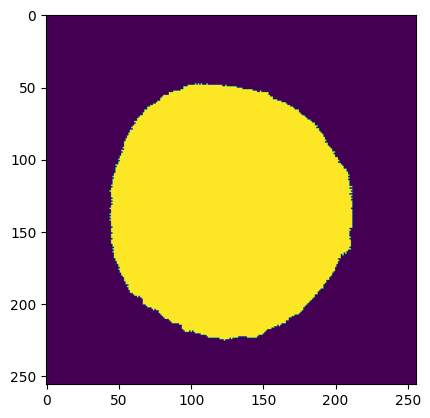

In [39]:
threshold = 0.5
linknet_model_disk.eval()
image = orig_image.resize((512, 512), resample=Image.NEAREST)
image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = linknet_model_disk(image)

output = output.detach().cpu().numpy()[0]
output = (output > threshold)
output = output.astype(np.uint8)
output = np.transpose(output, (1, 2, 0))

output = Image.fromarray(output.squeeze())
linknet_disk = output.resize((256, 256), resample=Image.NEAREST)
linknet_disk = np.array(linknet_disk)
print(linknet_disk.shape)
plt.imshow(linknet_disk)

### PSP-Net

(3, 256, 256)


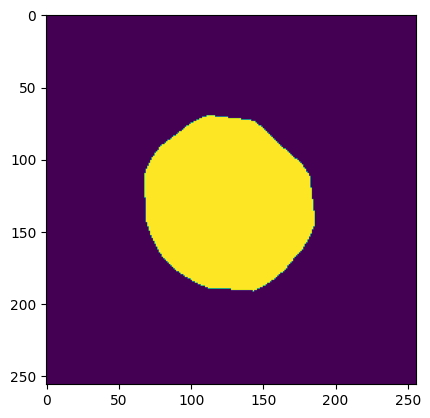

In [40]:
threshold = 0.5
pspnet_model_cup.eval()
image = orig_image.resize((256, 256), resample=Image.NEAREST)
#image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = pspnet_model_cup(image)

output = output.detach().cpu().numpy()[0]
output = (output > threshold)
print(output.shape)
output = np.transpose(output, (1, 2, 0))
pspnet_cup = output[:,:,2]
pspnet_cup = pspnet_cup.astype(np.uint8)
plt.imshow(pspnet_cup)

### Combination

In [41]:
merged_mask = np.zeros_like(linknet_disk)
merged_mask[linknet_disk == 1] = 1
merged_mask[pspnet_cup == 1] = 2
#plt.imshow(merged_mask)

In [42]:
overlay_image_predict = np.copy(orig_image.resize((256, 256), resample=Image.NEAREST))
overlay_image_predict[linknet_disk == 1] = 128
overlay_image_predict[pspnet_cup == 1] = 255
#plt.imshow(overlay_image_predict)

In [43]:
overlay_image_gt = np.copy(orig_image.resize((256, 256), resample=Image.NEAREST))
overlay_image_gt[orig_label == 1] = 128
overlay_image_gt[orig_label == 2] = 255
#plt.imshow(overlay_image_gt)

Text(0.5, 0, 'LinkNet + PSPNet overlay')

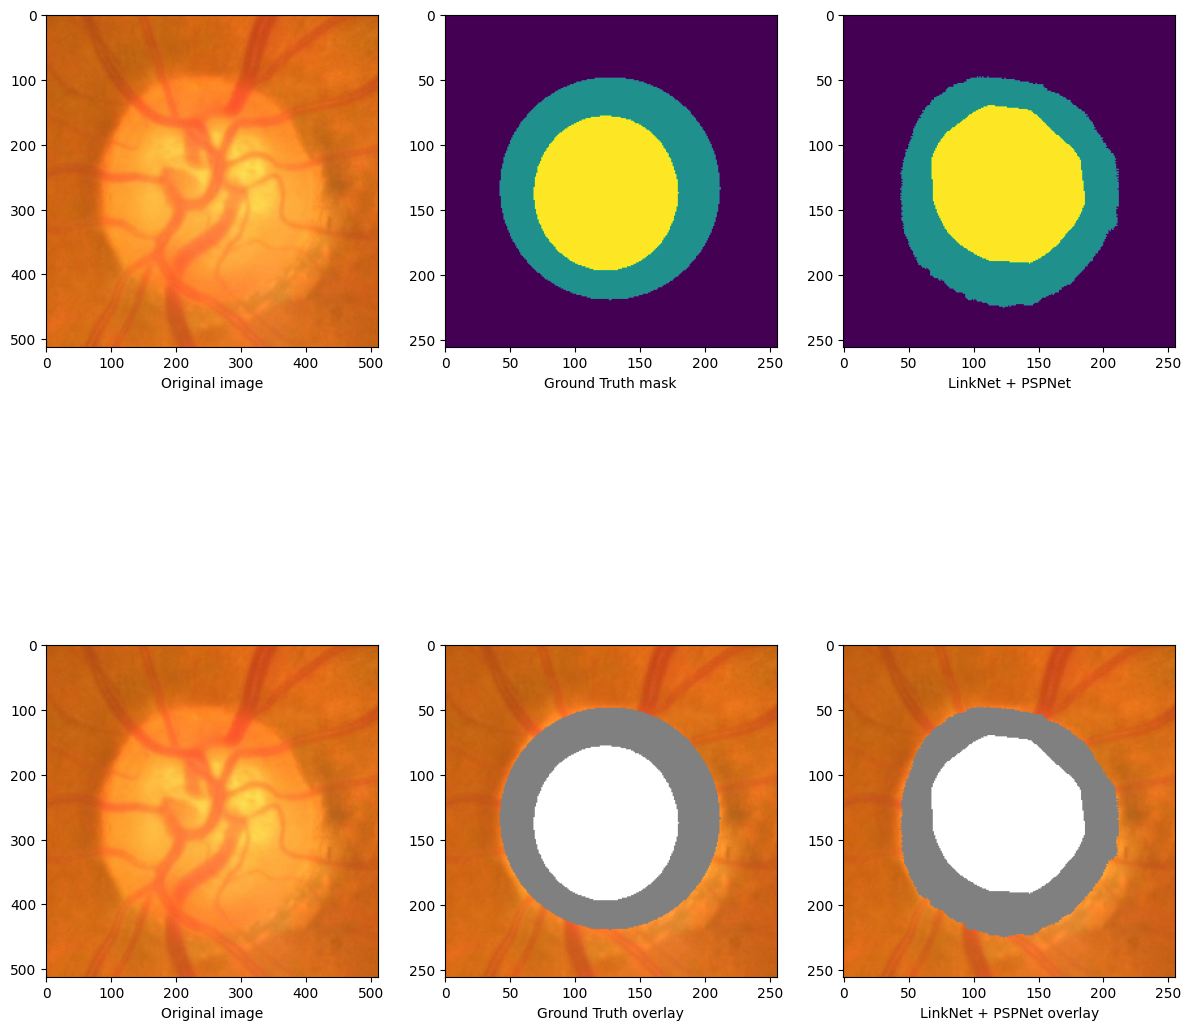

In [44]:
plt.figure(figsize=(30,30))
plt.subplot(2,6,1)  #2,4,1
plt.imshow(orig_image)
plt.xlabel("Original image")
plt.subplot(2,6,2)  #2,4,1
plt.imshow(orig_label) 
plt.xlabel("Ground Truth mask")
plt.subplot(2,6,3)   #
plt.imshow(merged_mask)
plt.xlabel("LinkNet + PSPNet")
plt.subplot(1,6,1)  #2,4,1
plt.imshow(orig_image)
plt.xlabel("Original image")
plt.subplot(1,6,2)   #2,4,2
plt.imshow(overlay_image_gt)
plt.xlabel("Ground Truth overlay")
plt.subplot(1,6,3)   #1,4,1
plt.imshow(overlay_image_predict)
plt.xlabel("LinkNet + PSPNet overlay")

In [24]:
# unique_values, counts = np.unique(orig_label, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(str(value) +":    "+str(count))

## PSP-Net only

### PSP-Net disk

(1, 256, 256)


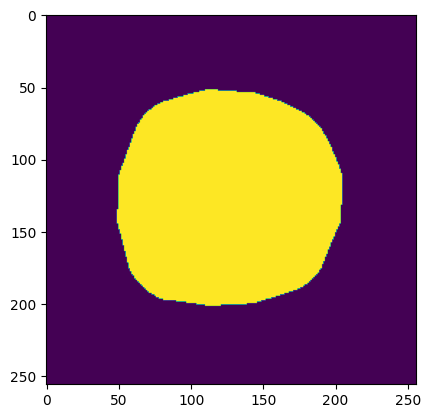

In [45]:
threshold = 0.5
pspnet_model_disk.eval()
image = orig_image.resize((256, 256), resample=Image.NEAREST)
#image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = pspnet_model_disk(image)

output = output.detach().cpu().numpy()[0]
output = (output > threshold)
print(output.shape)
output = np.transpose(output, (1, 2, 0))
pspnet_disk = output.squeeze()
pspnet_disk = pspnet_disk.astype(np.uint8)
plt.imshow(pspnet_disk)

### PSP-Net cup

(3, 256, 256)


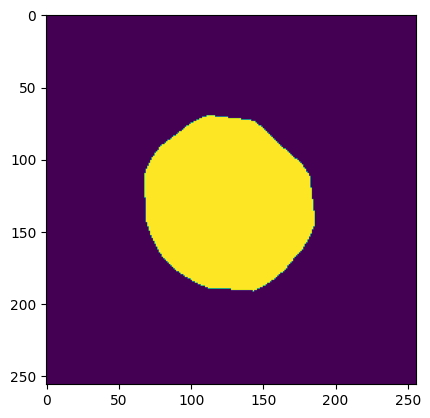

In [46]:
threshold = 0.5
pspnet_model_cup.eval()
image = orig_image.resize((256, 256), resample=Image.NEAREST)
#image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = pspnet_model_cup(image)

output = output.detach().cpu().numpy()[0]
output = (output > threshold)
print(output.shape)
output = np.transpose(output, (1, 2, 0))
pspnet_cup = output[:,:,2]
pspnet_cup = pspnet_cup.astype(np.uint8)
plt.imshow(pspnet_cup)

### Combination

In [47]:
merged_mask = np.zeros_like(pspnet_disk)
merged_mask[pspnet_disk == 1] = 1
merged_mask[pspnet_cup == 1] = 2
#plt.imshow(merged_mask)

In [48]:
overlay_image_predict = np.copy(orig_image.resize((256, 256), resample=Image.NEAREST))
overlay_image_predict[pspnet_disk == 1] = 128
overlay_image_predict[pspnet_cup == 1] = 255
#plt.imshow(overlay_image_predict)

In [49]:
overlay_image_gt = np.copy(orig_image.resize((256, 256), resample=Image.NEAREST))
overlay_image_gt[orig_label == 1] = 128
overlay_image_gt[orig_label == 2] = 255
#plt.imshow(overlay_image_gt)

Text(0.5, 0, 'PSPNet + PSPNet overlay')

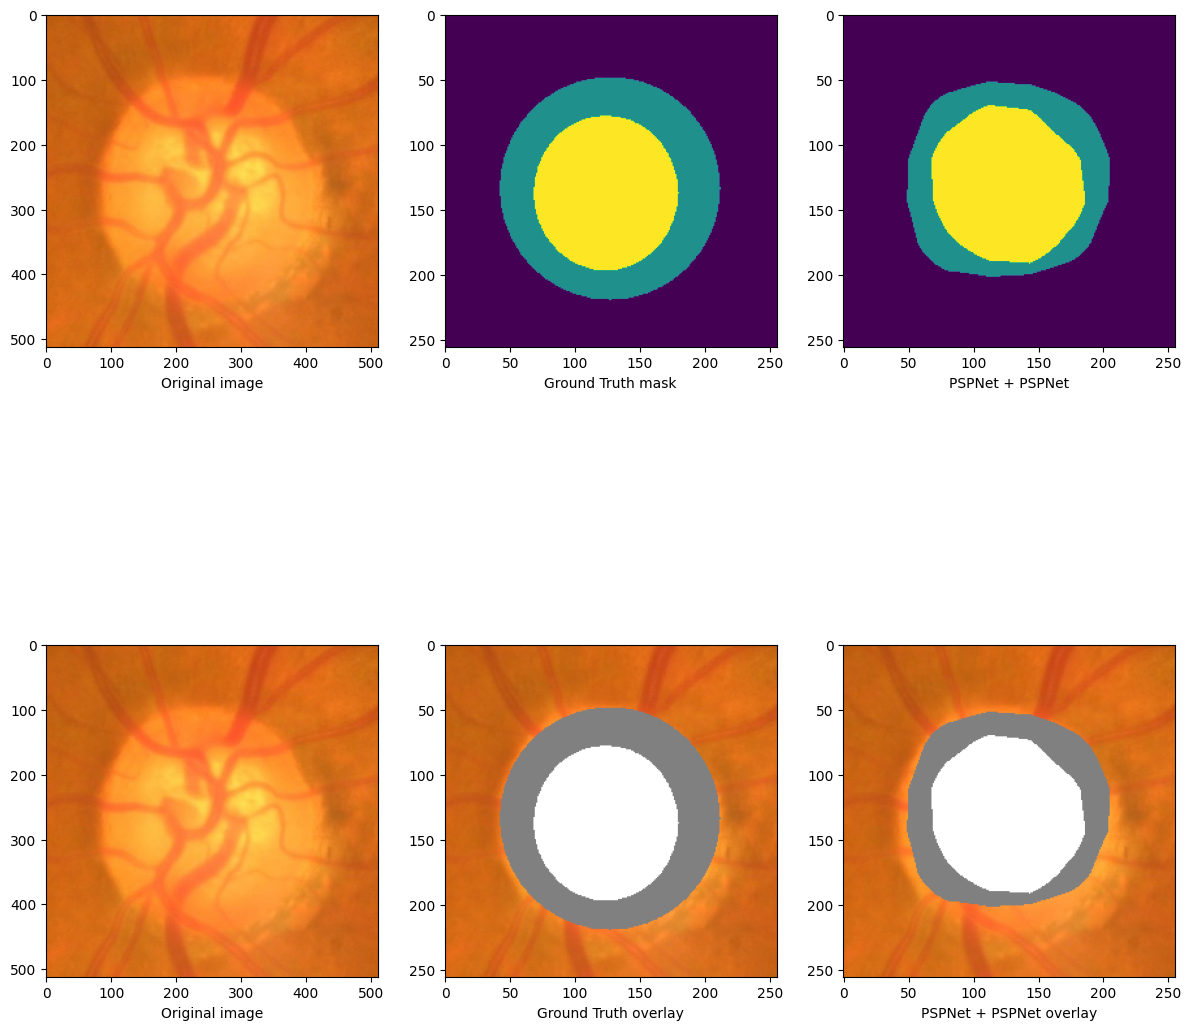

In [50]:
plt.figure(figsize=(30,30))
plt.subplot(2,6,1)  #2,4,1
plt.imshow(orig_image)
plt.xlabel("Original image")
plt.subplot(2,6,2)  #2,4,1
plt.imshow(orig_label) 
plt.xlabel("Ground Truth mask")
plt.subplot(2,6,3)   #
plt.imshow(merged_mask)
plt.xlabel("PSPNet + PSPNet")
plt.subplot(1,6,1)  #2,4,1
plt.imshow(orig_image)
plt.xlabel("Original image")
plt.subplot(1,6,2)   #2,4,2
plt.imshow(overlay_image_gt)
plt.xlabel("Ground Truth overlay")
plt.subplot(1,6,3)   #1,4,1
plt.imshow(overlay_image_predict)
plt.xlabel("PSPNet + PSPNet overlay")

In [31]:
# unique_values, counts = np.unique(pspnet_cup, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(str(value) +":    "+str(count))

## Automatic segmentation LinkNet + PSPNet

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


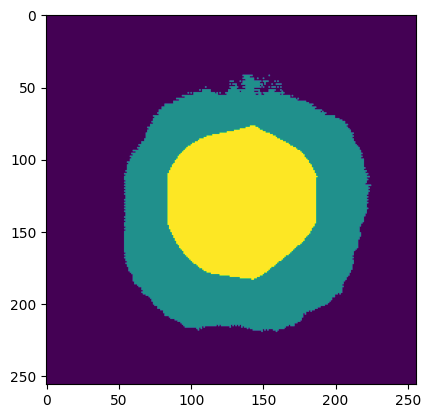

In [32]:
threshold = 0.5
linknet_model_disk.eval()
pspnet_model_cup.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        image = Image.open(image)
        image_disk = image.resize((512, 512), resample=Image.NEAREST)
        image_disk = image_disk.convert('L')
        image_disk = transform(image_disk)
        image_disk = image_disk.unsqueeze(0)
        
        image_disk = image_disk.to(device) 
        output_disk = linknet_model_disk(image_disk)
        
        output_disk = output_disk.detach().cpu().numpy()[0]
        output_disk = (output_disk > threshold)
        output_disk = output_disk.astype(np.uint8)
        output_disk = np.transpose(output_disk, (1, 2, 0))
        
        output_disk = Image.fromarray(output_disk.squeeze())
        linknet_disk = output_disk.resize((256, 256), resample=Image.NEAREST)
        linknet_disk = np.array(linknet_disk)

        image_cup = image.resize((256, 256), resample=Image.NEAREST)
        #image = image.convert('L')
        image_cup = transform(image_cup)
        image_cup = image_cup.unsqueeze(0)
        
        image_cup = image_cup.to(device) 
        output_cup = pspnet_model_cup(image_cup)
        
        output_cup = output_cup.detach().cpu().numpy()[0]
        output_cup = (output_cup > threshold)
        
        output_cup = np.transpose(output_cup, (1, 2, 0))
        pspnet_cup = output_cup[:,:,2]
        pspnet_cup = pspnet_cup.astype(np.uint8)

        merged_mask = np.zeros_like(linknet_disk)
        merged_mask[linknet_disk == 1] = 1
        merged_mask[pspnet_cup == 1] = 2

        print(merged_mask.shape)
        plt.imshow(merged_mask)

        output_dict = {"mask": merged_mask}
        savemat(test_results_psp_link + "\/" + filename.strip(".jpg") + ".mat", output_dict)

## Automatic segmentation PSPNet + PSPNet

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


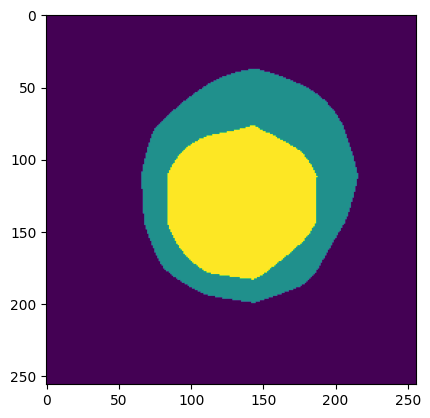

In [33]:
threshold = 0.5
pspnet_model_disk.eval()
pspnet_model_cup.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        image = Image.open(image)
        
        image_disk = image.resize((256, 256), resample=Image.NEAREST)
        image_disk = transform(image_disk)
        image_disk = image_disk.unsqueeze(0)
        
        image_disk = image_disk.to(device) 
        output_disk = pspnet_model_disk(image_disk)
        
        output_disk = output_disk.detach().cpu().numpy()[0]
        output_disk = (output_disk > threshold)
        output_disk = np.transpose(output_disk, (1, 2, 0))
        pspnet_disk = output_disk.squeeze()
        pspnet_disk = pspnet_disk.astype(np.uint8)

        image_cup = image.resize((256, 256), resample=Image.NEAREST)
        #image = image.convert('L')
        image_cup = transform(image_cup)
        image_cup = image_cup.unsqueeze(0)
        
        image_cup = image_cup.to(device) 
        output_cup = pspnet_model_cup(image_cup)
        
        output_cup = output_cup.detach().cpu().numpy()[0]
        output_cup = (output_cup > threshold)
        
        output_cup = np.transpose(output_cup, (1, 2, 0))
        pspnet_cup = output_cup[:,:,2]
        pspnet_cup = pspnet_cup.astype(np.uint8)

        merged_mask = np.zeros_like(pspnet_disk)
        merged_mask[pspnet_disk == 1] = 1
        merged_mask[pspnet_cup == 1] = 2

        print(merged_mask.shape)
        plt.imshow(merged_mask)
        
        output_dict = {"mask": merged_mask}
        savemat(test_results_psp_only + "\/" + filename.strip(".jpg") + ".mat", output_dict)